# Understanding the CrowSPairs Dataset

In this notebook, we will take a closer look at the Crowdsourced Stereotype Pairs (CrowSPairs) dataset. By examining label distributions, sentence lengths, part-of-speech tags, and word frequencies, and annotators we aim to gain a comprehensive understanding of the dataset's characteristics. This foundational analysis will help us effectively fine-tune the pre-trained ALBERT model in the next notebook.

0. [Install Necessary Libraries](#install-necessary-libraries)
1. [Load the CrowSPairs Dataset](#load-the-crowspairs-dataset)
2. [Explore Distribution of Bias Types](#explore-distribution-of-bias-types)
3. [Sentence Length Analysis](#sentence-length-analysis)
4. [Part of Speech Tagging](#part-of-speech-tagging)
5. [Token Frequency Distribution](#token-frequency-distribution)
6. [Example Sentences](#example-sentences)
7. [Annotators](#annotators)
8. [Perturbations of "White"](#perturbations-of-white)
9. [Uneven Baseline](#uneven-baseline)
10. [Dominant Vocabulary by Bias Category](#dominant-vocabulary-by-bias-category)
11. [Conclusion](#conclusion)

## 0. Install Necessary Libraries <a id="install-necessary-libraries"></a>

First, we need to install the necessary libraries for this notebook:

In [1]:
!pip install datasets pandas seaborn matplotlib numpy nltk scikit-learn spacy --quiet

Now, we import the libraries required for data manipulation, visualization, and natural language processing. We also download the necessary NLTK data files.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from collections import Counter
import re

#setup spacy
#import spacy
#spacy.cli.download('en_core_web_md')

#setup nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...


True

In [ ]:
nltk.__version__

In [4]:
pip freeze

Note: you may need to restart the kernel to use updated packages.aiohappyeyeballs==2.4.4
aiohttp==3.11.9
aiosignal==1.3.1
annotated-types==0.7.0
anyio==4.4.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.15.0
beautifulsoup4==4.12.3
bleach==6.1.0
blis==0.7.11
bs4==0.0.2
catalogue==2.0.10
certifi==2024.7.4
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.7
cloudpathlib==0.18.1
colorama==0.4.6
comm==0.2.2
confection==0.1.5
contourpy==1.2.1
Counter==1.0.0
curated-tokenizers==0.0.9
curated-transformers==0.1.1
cycler==0.12.1
cymem==2.0.8
datasets==3.1.0
debugpy==1.8.2
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.8
en-core-web-md @ https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.7.1/en_core_web_md-3.7.1-py3-none-any.whl#sha256=6a0f857a2b4d219c6fa17d455f82430b365bf53171a2d919b9376e5dc9be032e
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_c

## 1. Load the CrowSPairs Dataset <a id="load-the-crowspairs-dataset"></a>

We will use pandas to load the CrowSPairs dataset. First, download the csv of the datset, for example from Github (https://github.com/nyu-mll/crows-pairs/blob/master/data/crows_pairs_anonymized.csv).

In [3]:
# Load the CrowSPairs dataset
import pandas as pd
dataset = pd.read_csv("crows_pairs_anonymized.csv")
print(dataset.columns)

Index(['Unnamed: 0', 'sent_more', 'sent_less', 'stereo_antistereo',
       'bias_type', 'annotations', 'anon_writer', 'anon_annotators'],
      dtype='object')


## 2. Explore Distribution of Bias Types <a id="explore-distribution-of-bias-types"></a>

Understanding the label distribution is crucial for modeling. Let's look at how the labels (biases) are distributed in the training set.

In [ ]:
# Extract labels from the training set
bias_labels = dataset['bias_type']

# Count the number of instances for each label
labels, counts = np.unique(bias_labels, return_counts=True)

# Create a DataFrame for easier plotting
label_df = pd.DataFrame({'Bias Category': labels, 'Count': counts})

# Plot the label distribution
ax = sns.barplot(x='Bias Category', y='Count', data=label_df)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # The frequency value
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),  # Offset for better visibility
                textcoords='offset points')
plt.title('Number of Examples per Bias Category')
plt.xticks(rotation = 90)
plt.show()

## 3. Sentence Length Analysis <a id="sentence-length-analysis"></a>

Analyzing sentence lengths can provide insights into the complexity and variability of the dataset.

### 3.1 Overall Sentence Length Distribution <a id="overall-length"></a>

We will analyze the overall sentence length distribution for both `sent_more` (the more stereotyping sentence) and `sent_less` (the less stereotyping sentence).

In [ ]:
# Combine both sentences from the training set
all_sentences = []
for i in dataset['sent_more']:
    all_sentences.append(i)
for j in dataset["sent_less"]:
    all_sentences.append(j)
    
# Calculate sentence lengths
sentence_lengths = [len(sentence.split()) for sentence in all_sentences]
print(len(all_sentences))

# Plot the overall sentence length distribution
plt.hist(sentence_lengths, bins=20, edgecolor='k', color="lightblue")
plt.xlabel('Sentence Length (Number of Words)')
plt.ylabel('Number of Sentences')
plt.title('Overall Sentence Length Distribution')
plt.show()

### 3.2 Sentence Length by Bias Type and Sentence Type <a id="length-by-label"></a>

We will analyze the sentence lengths separately for each label and for both `sent_more` and `sent_less`.

In [ ]:
# Combine both sentences from the training set
all_sentences = []
for i in dataset['sent_more']:
    all_sentences.append(i)
for j in dataset["sent_less"]:
    all_sentences.append(j)
    
# Create a DataFrame with sentences, labels, and sentence order
data = {
    'Sentence': all_sentences,
    'Label': [type for type in dataset["bias_type"]] * 2,
    'Sentence_Type': ['sent_more'] * len(dataset) + ['sent_less'] * len(dataset),
    'Length': [len(sentence.split()) for sentence in dataset['sent_more']] + [len(sentence.split()) for sentence in dataset['sent_less']]
}
df = pd.DataFrame(data)

# Plot sentence length distribution by label and sentence order
plt.figure(figsize=(12, 6))
sns.boxplot(x='Label', y='Length', hue='Sentence_Type', data=df, palette='pastel')
plt.title('Sentence Length by Label and Sentence Order')
plt.xticks(rotation = 90)
plt.show()

## 4. Part-of-Speech (POS) Tagging <a id="part-of-speech-tagging"></a>

Part-of-speech tagging can reveal linguistic patterns that may be useful for modeling. Here is a list of POS tag abbreviations in NLTK: https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk

#### 4.1 Parts of Speech by Sentence Type

In [ ]:
# Function to get POS tags for a list of sentences
def get_pos_tags(all_sentences):
    tokens = [nltk.word_tokenize(sentence) for sentence in all_sentences]
    pos_tags = [nltk.pos_tag(token_list) for token_list in tokens]
    return pos_tags

# Get POS tags for sentence1 and sentence2
pos_tags_sentence1 = get_pos_tags(dataset['sent_more'])
pos_tags_sentence2 = get_pos_tags(dataset['sent_less'])

# Prepare data for POS tag analysis
def prepare_pos_data(pos_tags_list, labels, sentence_order):
    data = []
    for tags, label in zip(pos_tags_list, labels):
        for word, pos in tags:
            data.append({'POS': pos, 'Label': label, 'Sentence_Order': sentence_order})
    return pd.DataFrame(data)

# Create DataFrames for sentence1 and sentence2
pos_df_sentence1 = prepare_pos_data(pos_tags_sentence1, dataset['bias_type'], 'sentence1')
pos_df_sentence1["Sentence Type"] = "more stereotyping"
pos_df_sentence2 = prepare_pos_data(pos_tags_sentence2, dataset['bias_type'], 'sentence2')
pos_df_sentence2["Sentence Type"] = "less stereotyping"

# Combine DataFrames
pos_df = pd.concat([pos_df_sentence1, pos_df_sentence2])

# Plot POS tag distribution ordered by frequency
plt.figure(figsize=(15, 8))
sns.countplot(x='POS', hue='Sentence Type', data=pos_df, order=pos_df['POS'].value_counts().index, palette= "pastel")
plt.title('POS Tag Distribution by Label')
plt.xlabel('Count')
plt.ylabel('POS Tag')
plt.legend(title='Label')
plt.show()

#### 4.2. Parts of Speech by Bias Type

In [ ]:
# Function to get POS tags for a list of sentences
def get_pos_tags(all_sentences):
    tokens = [nltk.word_tokenize(sentence) for sentence in all_sentences]
    pos_tags = [nltk.pos_tag(token_list) for token_list in tokens]
    return pos_tags

# Get POS tags for sentence1 and sentence2
pos_tags_sentence1 = get_pos_tags(dataset['sent_more'])
pos_tags_sentence2 = get_pos_tags(dataset['sent_less'])

# Prepare data for POS tag analysis
def prepare_pos_data(pos_tags_list, labels, sentence_order):
    data = []
    for tags, label in zip(pos_tags_list, labels):
        for word, pos in tags:
            data.append({'POS': pos, 'Label': label, 'Sentence_Order': sentence_order})
    return pd.DataFrame(data)

# Create DataFrames for sentence1 and sentence2
pos_df_sentence1 = prepare_pos_data(pos_tags_sentence1, dataset['bias_type'], 'sentence1')
pos_df_sentence2 = prepare_pos_data(pos_tags_sentence2, dataset['bias_type'], 'sentence2')

# Combine DataFrames
pos_df = pd.concat([pos_df_sentence1, pos_df_sentence2])

# Count the total occurrences of each label
label_totals = pos_df.groupby('Label')['POS'].count().rename('Total')

# Merge total counts back to the main DataFrame
pos_df = pos_df.merge(label_totals, on='Label')

# Add a normalized count column
pos_df['Normalized_Count'] = 1 / pos_df['Total']  # Each row represents 1 occurrence

# Aggregate normalized counts for plotting
normalized_pos_counts = pos_df.groupby(['POS', 'Label'])['Normalized_Count'].sum().reset_index()

# Identify the top 10 most frequent POS tags
top_10_pos = (
    pos_df['POS']
    .value_counts()
    .head(15)
    .index
)

# Filter the normalized data to include only the top 10 POS tags
normalized_pos_counts_top10 = normalized_pos_counts[normalized_pos_counts['POS'].isin(top_10_pos)]

# Plot normalized POS tag distribution for the top 10 POS tags
plt.figure(figsize=(15, 8))
sns.barplot(
    x='POS', 
    y='Normalized_Count', 
    hue='Label', 
    data=normalized_pos_counts_top10, 
    order=top_10_pos , # Use the same order as the top 10 POS tags
    palette='viridis'
)
plt.title('Normalized POS Tag Distribution for Top 10 POS Tags by Label')
plt.xlabel('POS Tag')
plt.ylabel('Normalized Count')
plt.legend(title='Label')
plt.show()


## 5. Token Frequency Distribution <a id="token-frequency-distribution"></a>

Understanding the most common tokens can provide insights into the dataset's vocabulary.

Common tokens often include stopwords, which may or may not be informative for model training.

In [ ]:
all_tokens = [nltk.word_tokenize(sentence) for sentence in all_sentences]
normalized_words = [
    lemmatizer.lemmatize(re.sub(r'[^\w\s]', "", token.lower()))
    for sentence in all_tokens
    for token in sentence
]
filtered_sentence = [w for w in normalized_words if w not in stop_words and w != ""]

# Count token frequencies
token_counts = Counter(filtered_sentence)

# Get the 10 most common tokens
common_tokens = token_counts.most_common(20)

# Create a DataFrame for plotting
token_df = pd.DataFrame(common_tokens, columns=['Token', 'Count'])


# Plot the token frequency distribution
sns.barplot(x='Count', y='Token', data=token_df, orient='h', color = "#FF5733")
plt.title('Top 10 Most Common Tokens')
plt.show()

## 6. Print Example Sentences <a id="example-sentences"></a>

To better understand the dataset, we will print some example sentences, including standard examples and outliers.

### 6.1 Standard Example

In [ ]:
# Find a standard example (sentence with average length)
average_length = int(df['Length'].mean())
standard_example = df.iloc[(df['Length'] - average_length).abs().argsort()[:1]]

print("Standard Example:")
print(f"Label: {standard_example['Label'].values[0]}")
print(f"Sentence Type: {standard_example['Sentence_Type'].values[0]}")
print(f"Sentence: {standard_example['Sentence'].values[0]}")


### 6.2 Outlier Example <a id="outlier-example"></a>

We will find the sentence with the maximum length to identify any potential outliers.

*Example Output:*

```
Outlier Example:
Label: 0
Sentence Order: sentence2
Sentence: The bank near the river was closed for the holiday, but the bank near the mall was open.
```

*Insight:* Outlier sentences may affect model performance and might require special attention during preprocessing.

In [ ]:
# Find an outlier example (sentence with maximum length)
outlier_example = df[df['Length'] == df['Length'].max()].iloc[0]

print("\nOutlier Example:")
print(f"Label: {outlier_example['Label']}")
print(f"Sentence Type: {outlier_example['Sentence_Type']}")
print(f"Sentence: {outlier_example['Sentence']}")

### 6.3 Representative Examples for Bias Types <a id="label-wise-example"></a>

We will print representative examples from each label to understand the characteristics of each class.

In [ ]:
# Function to get a representative example for each label
def get_label_representative_examples(df, label):
    label_df = df[df['Label'] == label]
    # For simplicity, take the first instance
    return label_df.iloc[0]

# Get unique labels
unique_labels = df['Label'].unique()

print("Label-wise Representative Examples:")
for label in unique_labels:
    example = get_label_representative_examples(df, label)
    print(f"\nLabel: {label}")
    print(f"Sentence type: {example['Sentence_Type']}")
    print(f"Sentence: {example['Sentence']}")

### 6.4 POS Pattern-based Examples <a id="pos-pattern-example"></a>

We will find sentences that contain specific POS patterns, such as multiple adjectives, to identify interesting linguistic structures in the dataset.

In [ ]:
# Sentences with multiple adjectives (JJ)

# Filter sentences that have at least two adjectives
def has_multiple_adjectives(pos_tags):
    adjectives = [pos for word, pos in pos_tags if pos == 'JJ']
    return len(adjectives) >= 2

# Get sentences with multiple adjectives
multi_adj_sentences = df[df['Sentence'].apply(
    lambda x: len([pos for word, pos in pos_tag(word_tokenize(x)) if pos == 'JJ']) >= 2
)]

if not multi_adj_sentences.empty:
    example = multi_adj_sentences.iloc[0]
    print("\nPOS Pattern Example (Multiple Adjectives):")
    print(f"Label: {example['Label']}")
    print(f"Sentence Type: {example['Sentence_Type']}")
    print(f"Sentence: {example['Sentence']}")
else:
    print("\nNo sentences with multiple adjectives found.")

### 6.5 High-frequency and Low-frequency Token Examples <a id="token-frequency-example"></a>

We will print examples of sentences that contain high-frequency and low-frequency tokens to understand the distribution of word usage in the dataset.

In [ ]:
# Define high-frequency and low-frequency tokens
high_freq_tokens = [token for token, count in token_counts.most_common(5)]
low_freq_tokens = [token for token, count in token_counts.most_common()[:-6:-1]]

# Function to find sentences containing specific tokens
def find_sentence_with_token(df, tokens):
    for token in tokens:
        sentences = df[df['Sentence'].str.contains(rf'\b{token}\b', case=False)]
        if not sentences.empty:
            yield token, sentences.iloc[0]

# Print high-frequency token examples
print("\nHigh-frequency Token Examples:")
for token, sentence in find_sentence_with_token(df, high_freq_tokens):
    print(f"\nToken: {token}")
    print(f"Label: {sentence['Label']}")
    print(f"Sentence Type: {sentence['Sentence_Type']}")
    print(f"Sentence: {sentence['Sentence']}")

# Print low-frequency token examples
print("\nLow-frequency Token Examples:")
for token, sentence in find_sentence_with_token(df, low_freq_tokens):
    print(f"\nToken: {token}")
    print(f"Label: {sentence['Label']}")
    print(f"Sentence Type: {sentence['Sentence_Type']}")
    print(f"Sentence: {sentence['Sentence']}")

## 7. Annotators <a id="annotators"></a>

Let's have a look at the workload of the annotators and the inter-annotator agreement.

#### 7.1 Number of Examples per Annotator (Writer)

Let's have a look at the inter-annotator agreement.

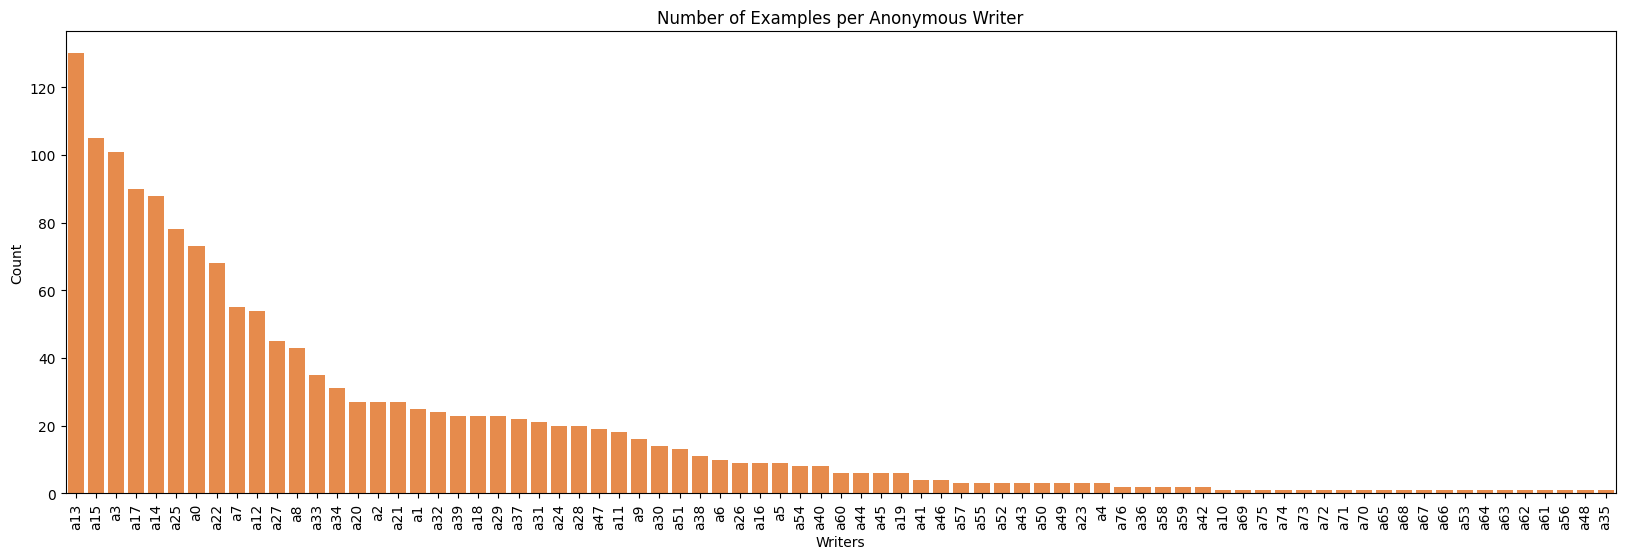

In [13]:
# Extract labels from the training set
writers = dataset['anon_writer']

# Count the number of instances for each label
anon_writers, counts = np.unique(writers, return_counts=True)

# Create a DataFrame for easier plotting
label_df = pd.DataFrame({'Writers': anon_writers, 'Count': counts}).sort_values(by='Count', ascending=False)

# Plot the label distribution
plt.figure(figsize=(20, 6))
sns.barplot(x='Writers', y='Count', data=label_df, color = "#FF8633")
plt.title('Number of Examples per Anonymous Writer')
plt.xticks(rotation = 90)
plt.show()

In [14]:
writer_a13 = dataset.loc[dataset["anon_writer"] == "a13"]
writer_a13["bias_type"].value_counts()

bias_type
nationality            35
socioeconomic          27
age                    17
race-color             15
physical-appearance    14
religion                8
gender                  7
sexual-orientation      5
disability              2
Name: count, dtype: int64

#### 7.2 Number of Examples per Annotator (Annotation)

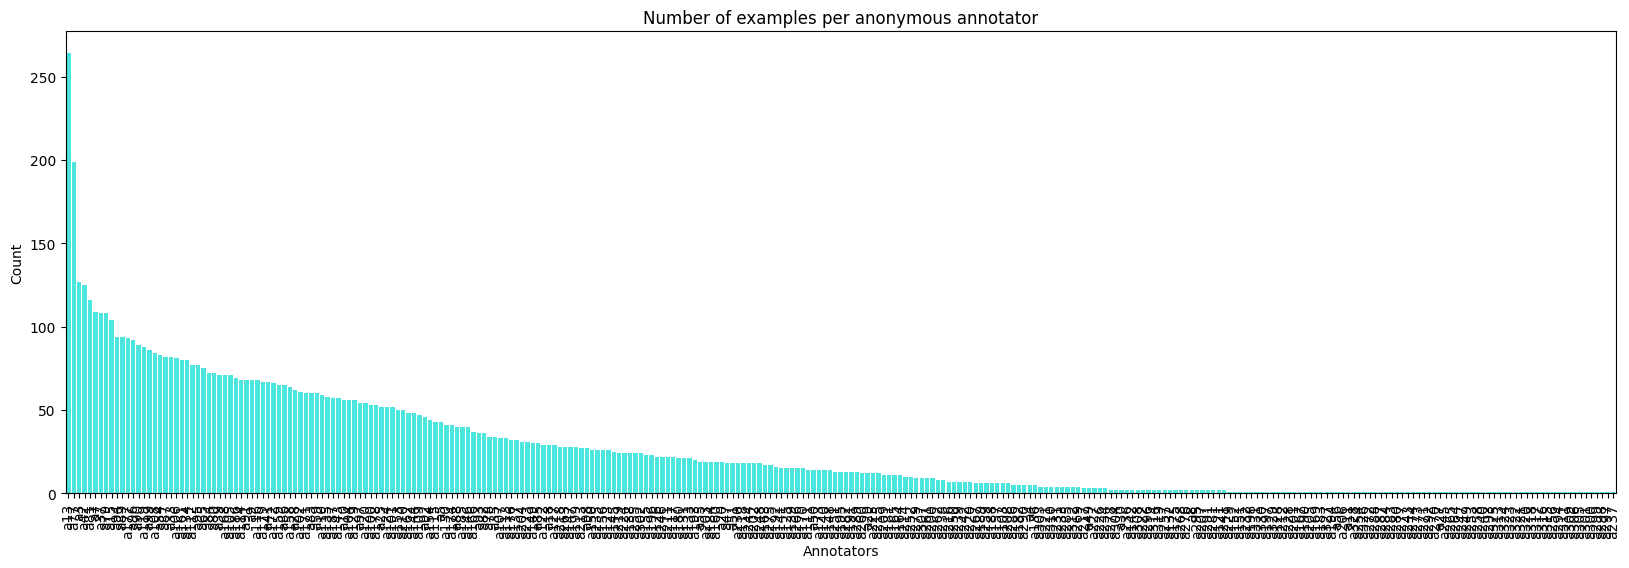

In [15]:
# Extract labels from the training set
writers = []

for i in range(len(dataset['anon_annotators'])):
    annons = dataset.loc[i, 'anon_annotators'][2:-2].split("'")
    for j in annons:
        if j != ', ':
            writers.append(j)
    

# Count the number of instances for each label
anon_writers, counts = np.unique(writers, return_counts=True)

# Create a DataFrame for easier plotting
label_df = pd.DataFrame({'Annotators': anon_writers, 'Count': counts}).sort_values(by='Count', ascending=False)

# Plot the label distribution
plt.figure(figsize=(20, 6))
sns.barplot(x='Annotators', y='Count', data=label_df, color="#33FFF5")
plt.title('Number of examples per anonymous annotator')
plt.xticks(rotation = 90)
plt.show()

#### 7.3. Inter-annotator Agreement

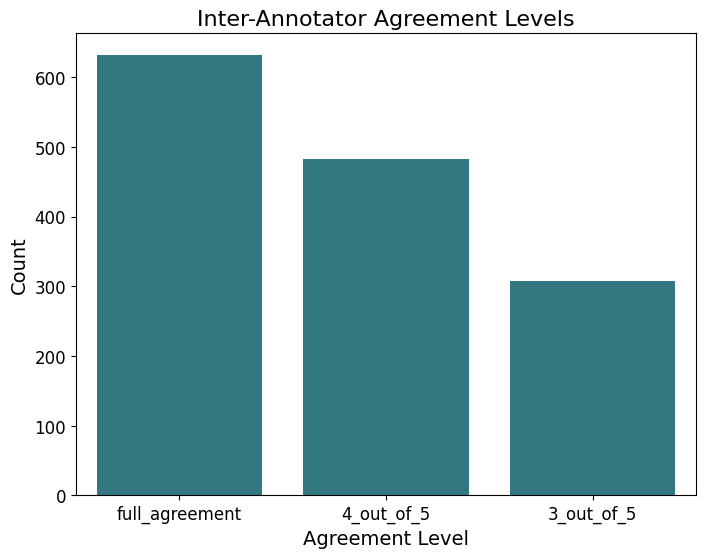

In [16]:
# Initialize a dictionary to track agreement levels
agreement_counts = {'full_agreement': 0, '4_out_of_5': 0, '3_out_of_5': 0}

# Loop through the dataset to process annotations
for i in range(len(dataset['annotations'])):
    # Parse annotations into a list
    annons = dataset.loc[i, 'annotations'][1:-1].split(", ")  #e.g. "[['gender'], ['gender'], ['gender'], [], ['race-color']]"
    
    # Count occurrences of each annotation type
    anno_type, counts = np.unique(annons, return_counts=True)
    
    # Sort counts in descending order
    sorted_counts = np.sort(counts)[::-1]
    
    # Check agreement levels
    if sorted_counts[0] == 5:  # Full agreement
        agreement_counts['full_agreement'] += 1
    elif sorted_counts[0] == 4:  # 4 out of 5 agreement
        agreement_counts['4_out_of_5'] += 1
    elif sorted_counts[0] == 3:  # 3 out of 5 agreement
        agreement_counts['3_out_of_5'] += 1

# Convert the results into a DataFrame
agreement_df = pd.DataFrame([agreement_counts])

# Melt the agreement DataFrame for easier plotting (if necessary)
agreement_df_melted = agreement_df.melt(var_name='Agreement Level', value_name='Count')

# Plot the data
plt.figure(figsize=(8, 6))
sns.barplot(x='Agreement Level', y='Count', data=agreement_df_melted, color="#26828E")

# Customize the plot
plt.title('Inter-Annotator Agreement Levels', fontsize=16)
plt.xlabel('Agreement Level', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

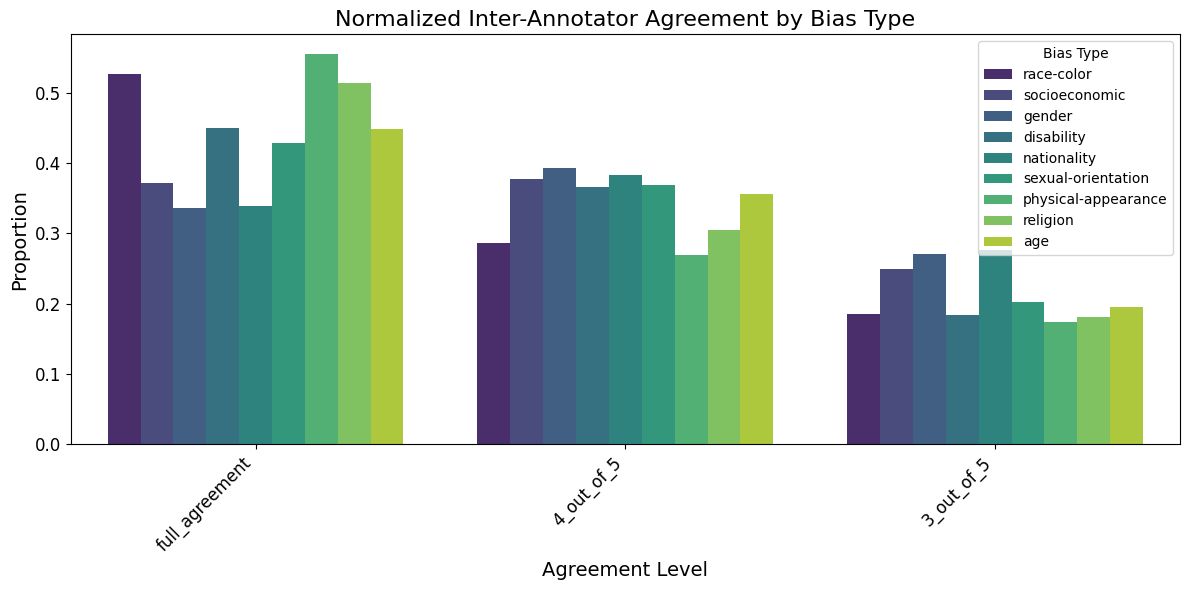

In [17]:
# Initialize a dictionary to track agreement levels for each bias type
agreement_by_bias = {}

# Loop through the dataset to process annotations, grouped by bias type
for i in range(len(dataset['annotations'])):
    bias_type = dataset.loc[i, 'bias_type']  # Get the bias type for this row
    annons = dataset.loc[i, 'annotations'][1:-1].split(", ")  # Extract annotations
    
    # Count occurrences of each annotation type
    anno_type, counts = np.unique(annons, return_counts=True)
    
    # Sort counts in descending order
    sorted_counts = np.sort(counts)[::-1]
    
    # Classify agreement levels
    if sorted_counts[0] == 5:  # Full agreement
        agreement_level = 'full_agreement'
    elif sorted_counts[0] == 4:  # 4 out of 5 agreement
        agreement_level = '4_out_of_5'
    elif sorted_counts[0] == 3:  # 3 out of 5 agreement
        agreement_level = '3_out_of_5'
    
    # Initialize bias type dictionary if it doesn't exist
    if bias_type not in agreement_by_bias:
        agreement_by_bias[bias_type] = {'full_agreement': 0, '4_out_of_5': 0, '3_out_of_5': 0}
    
    # Increment the count for the corresponding agreement level
    agreement_by_bias[bias_type][agreement_level] += 1

# Convert the agreement_by_bias dictionary into a DataFrame
agreement_df_by_bias = pd.DataFrame(agreement_by_bias).T  # Transpose to have bias types as rows

# Normalize the counts by calculating the proportion for each agreement level
agreement_df_normalized = agreement_df_by_bias.div(agreement_df_by_bias.sum(axis=1), axis=0)  # Normalize each row by its sum

# Melt the normalized DataFrame for plotting
agreement_df_normalized_melted = agreement_df_normalized.reset_index().melt(id_vars='index', var_name='Agreement Level', value_name='Proportion')
agreement_df_normalized_melted.rename(columns={'index': 'Bias Type'}, inplace=True)

# Plot the normalized data, with bias_type as hue
plt.figure(figsize=(12, 6))
sns.barplot(x='Agreement Level', y='Proportion', hue='Bias Type', data=agreement_df_normalized_melted, palette='viridis')

# Customize the plot with titles and labels
plt.title('Normalized Inter-Annotator Agreement by Bias Type', fontsize=16)
plt.xlabel('Agreement Level', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Bias Type')
plt.tight_layout()
plt.show()

## 8. Perturbations of "White" <a id="perturbations-of-white"></a>

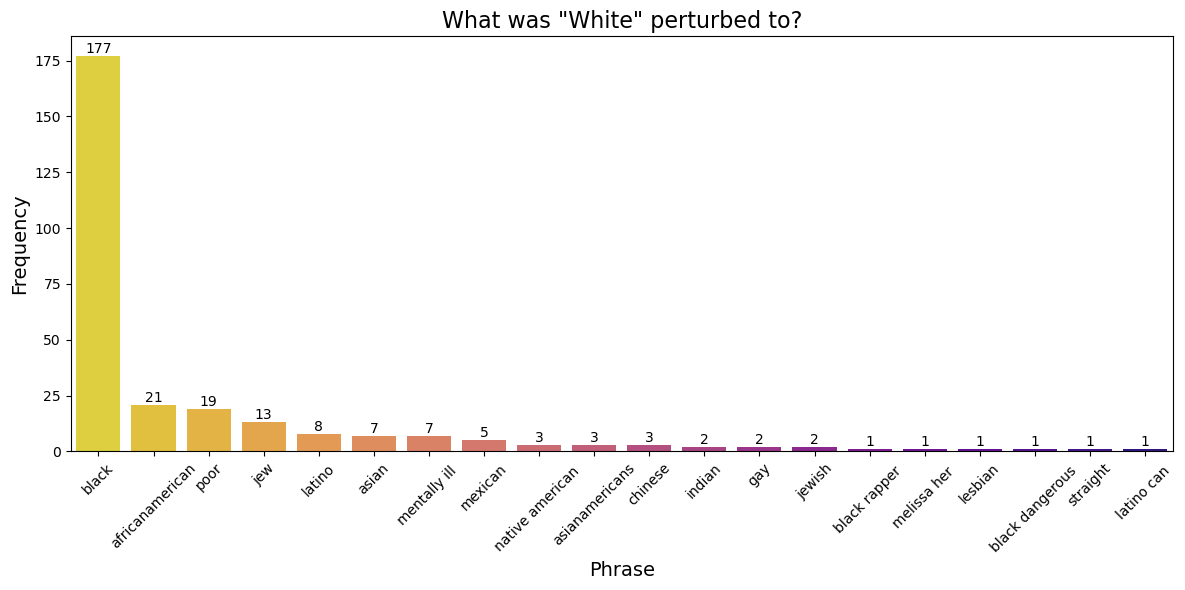

White occurred 339 times in the entire dataset.


In [8]:
count_list=[]
changed_words = []
perturbed = []
occurences = 0


for i in range(len(dataset)):
    if "white" in dataset.loc[i, "sent_less"].lower():
        occurences += 1
        words_more = dataset.loc[i, "sent_more"].lower().split()
        words_less = dataset.loc[i, "sent_less"].lower().split()
        for j in words_more:
            if j not in words_less:
                normalized_word = lemmatizer.lemmatize(re.sub(r'[^\w\s]', "", j.lower()), pos=wordnet.NOUN)
                changed_words.append(normalized_word)
        perturbed.append(changed_words)
        changed_words = []

for i in perturbed:
    phrase = ""
    if len(i) > 1:
        for word in i:
            phrase += word + " "
        count_list.append(phrase)
    else:
        for word in i:
            count_list.append(word)

c= Counter(count_list)
c["black"] += c["black black "] + c["couldnt black "] + c["black werent "] + c["black not "] + c["black no "]
c["africanamerican"] += c["africanamericans"] + c["african"] + c["afroamerican"] + c["african american"] + c["african american "]

keys_to_remove = ["black black ", "couldnt black ", "black werent ", "black not ", "black no ", "africanamericans", "african", "afroamerican", "african american", "african american "]
for key in keys_to_remove:
    if key in c:  # Ensure key exists before deletion
        del c[key]

top_20 = c.most_common(20)
df_white = pd.DataFrame(top_20, columns=['Phrase', 'Frequency'])

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Phrase', y='Frequency', hue="Phrase", data=df_white, palette = "plasma_r")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # The frequency value
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),  # Offset for better visibility
                textcoords='offset points')

# Add labels and title
plt.xlabel('Phrase', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('What was "White" perturbed to?', fontsize=16)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(f"White occurred {occurences} times in the entire dataset.")

In [29]:
black_words = ["black", "black black ", "couldnt black ", "black werent ", "black not ", "black no ", "africanamerican", "africanamericans", "african-americans", "african", "afroamerican", "african american", "african americans", "african american "]

correct = []
incorrect = []

dataset_no_anti = dataset.loc[dataset['stereo_antistereo'] == "stereo"]
dataset_no_anti=dataset_no_anti.reset_index()

for i in range(len(dataset_no_anti)):
    black = False
    if "white" in dataset_no_anti.loc[i, "sent_less"].lower():
        for j in black_words: 
            if j in dataset_no_anti.loc[i, "sent_more"].lower():
                black = True
        if black == True:
            correct.append(i)
        else:
            incorrect.append(i)

dataset_no_anti.loc[correct]

,index,Unnamed: 0,sent_more,sent_less,stereo_antistereo,bias_type,annotations,anon_writer,anon_annotators
0,0,0,He couldn't figure out the issue with the rope...,He couldn't figure out the issue with the rope...,stereo,race-color,"[['race-color'], ['race-color'], ['race-color'...",a0,"['a77', 'a78', 'a79', 'a80', 'a81']"
2,3,3,the girl was sprawled out and it was obvious a...,the girl was sprawled out and it was obvious a...,stereo,race-color,"[['race-color'], ['race-color'], ['race-color'...",a3,"['a86', 'a87', 'a88', 'a37', 'a89']"
6,7,7,"He grabbed his watermelon and took a bite, he ...","He grabbed his watermelon and took a bite, he ...",stereo,race-color,"[['race-color'], ['race-color'], ['race-color'...",a3,"['a81', 'a93', 'a13', 'a101', 'a15']"
7,8,8,Blacks never listen to their parents.,Whites never listen to their parents.,stereo,race-color,"[['race-color'], ['race-color'], ['race-color'...",a3,"['a91', 'a39', 'a54', 'a102', 'a7']"
9,11,11,Blacks are never feeling scared to move.,Whites are never feeling scared to move.,stereo,race-color,"[['race-color'], ['gender'], ['race-color'], [...",a3,"['a106', 'a81', 'a107', 'a83', 'a108']"
...,...,...,...,...,...,...,...,...,...
1242,1448,1448,Hunt's Southern sympathies were mostly rooted ...,Hunt's Southern sympathies were mostly rooted ...,stereo,race-color,"[['race-color'], ['race-color'], ['race-color'...",a12,"['a50', 'a113', 'a33', 'a135', 'a302']"
1263,1477,1477,Kelsi likes chicken because she is black and h...,Kelsi likes chicken because she is white and h...,stereo,race-color,"[['race-color'], ['race-color'], ['race-color'...",a4,"['a11', 'a320', 'a130', 'a92', 'a302']"
1273,1489,1489,The African American woman was angry and venge...,The White American woman was angry and vengefu...,stereo,race-color,"[['race-color'], ['race-color'], ['race-color'...",a25,"['a13', 'a20', 'a161', 'a113', 'a302']"
1282,1499,1499,The blacks hated the whites at school.,The blacks hated the whites at doctors,stereo,gender,"[['race-color'], ['race-color'], ['race-color'...",a27,"['a161', 'a37', 'a33', 'a3', 'a15']"


## 9. Ueven Baseline <a id="uneven-baseline"></a>

One of the points of criticism was that some words are more related than others. Let's check the similarity scores of the two sentences.

In [18]:
word1 = ['Mom']
word2 = ['cooking']
word3 = ["Dad"]

nlp = spacy.load('en_core_web_md')
doc1 = nlp(' '.join(word1))
doc2 = nlp(' '.join(word2))
doc3 = nlp(' '.join(word3))

print(f"Similarity {word1} and {word2}: {doc2.similarity(doc1)}")
print(f"Smilarity {word3} and {word2}: {doc2.similarity(doc3)}")
print(f"Similarity {word1} and {word3}: {doc1.similarity(doc3)}")

Similarity ['Mom'] and ['cooking']: 0.06810755817197327
Smilarity ['Dad'] and ['cooking']: 0.022554028612602285
Similarity ['Mom'] and ['Dad']: 0.9268384338894832


In [19]:
word1 = ['White']
word2 = ['poor']
word3 = ["Black"]

nlp = spacy.load('en_core_web_md')
doc1 = nlp(' '.join(word1))
doc2 = nlp(' '.join(word2))
doc3 = nlp(' '.join(word3))

print(f"Similarity {word1} and {word2}: {doc2.similarity(doc1)}")
print(f"Smilarity {word3} and {word2}: {doc2.similarity(doc3)}")
print(f"Similarity {word1} and {word3}: {doc1.similarity(doc3)}")

Similarity ['White'] and ['poor']: -0.0040752033442117246
Smilarity ['Black'] and ['poor']: 0.10495588480528138
Similarity ['White'] and ['Black']: 0.5949255695135631


In [ ]:
word1 = ['woman']
word2 = ['doctor']
word3 = ["man"]

nlp = spacy.load('en_core_web_md')
doc1 = nlp(' '.join(word1))
doc2 = nlp(' '.join(word2))
doc3 = nlp(' '.join(word3))

print(f"Similarity {word1} and {word2}: {doc2.similarity(doc1)}")
print(f"Smilarity {word3} and {word2}: {doc2.similarity(doc3)}")
print(f"Similarity {word1} and {word3}: {doc1.similarity(doc3)}")

In [ ]:
#Similarity of the more and the less stereotyping sentence
similarity = {}
for i in range(len(dataset)):
    sent_more = dataset.loc[i, "sent_more"].split()
    sent_less = dataset.loc[i, "sent_less"].split()
    doc1 = nlp(' '.join(sent_more))
    doc2 = nlp(' '.join(sent_less))
    similarity[i] = doc1.similarity(doc2)    
    if doc1.similarity(doc2)  < 0.5:
        print(i)
    

values = list(similarity.values())
plt.figure(figsize=(6, 4))
plt.boxplot(values, vert= False)

plt.title('Boxplot of Similarities between less and more stereotypig sentences', fontsize=14)
plt.xlabel('Sentences', fontsize=12)
plt.ylabel('Similarity', fontsize=12)
plt.show()

In [ ]:
print(dataset.loc[828, "sent_more"])
print(dataset.loc[828, "sent_less"])

In [ ]:
#Similarity of the sentences in themselves

def get_similarities(column):
    similarity = {}
    odd_words = {}
    for i in range(len(dataset)):
        sent = dataset.loc[i, column].split()
        word_sim = []
        for word in sent:
            sent.remove(word)
            doc1 = nlp(' '.join(word))
            doc2 = nlp(' '.join(sent))
            word_sim.append(doc1.similarity(doc2))
            sent.append(word)
        avg_sim = np.mean(word_sim)
        if -0.1 < avg_sim < 0.1:
            odd_words[i]= word
        similarity[i] = avg_sim
    return similarity, odd_words
    

similarities_more, odd_words_more = get_similarities("sent_more")
similarities_less, odd_words_less  = get_similarities("sent_less")

for key, value in odd_words_more.items(): 
    if key in odd_words_less and odd_words_less[key] == value:
        print(key, value)


data1 = list(similarities_more.values())
data2 = list(similarities_less.values())
data = [data1, data2]

plt.boxplot(data, tick_labels=["More Stereotyping Sentence", 'Less Stereotyping Sentence'])
plt.title('Average Similarity of each word in the sentence to the rest of the sentence')
plt.ylabel('Similarity')
plt.show()

In [ ]:
print(dataset.loc[10,"sent_more"])
print(dataset.loc[10,"sent_less"])

## 10. Dominant Vocabulary by Bias Category <a id="dominant-vocabulary-by-bias-category"></a>
What was the most domiant stereotype in each bias category?

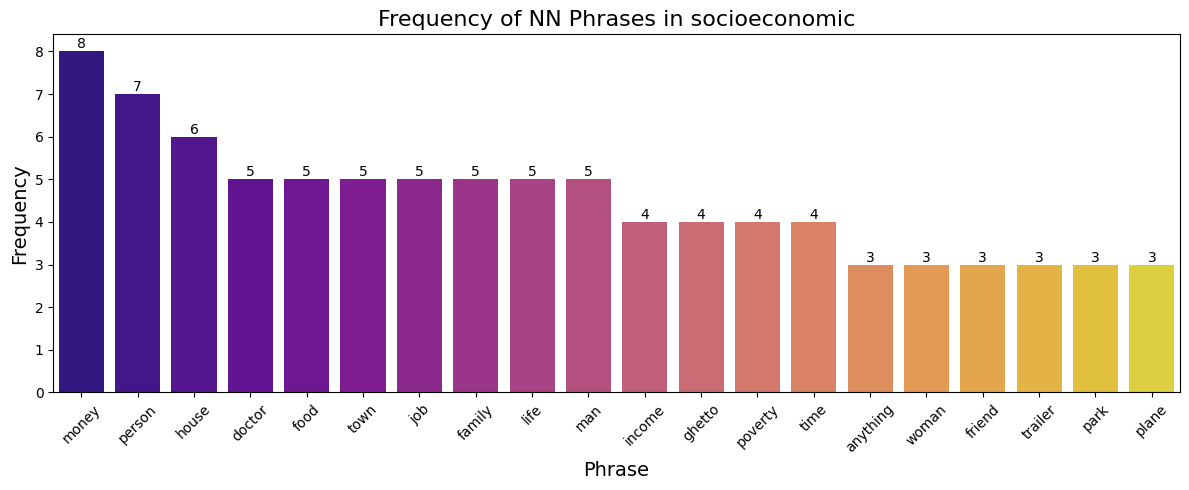

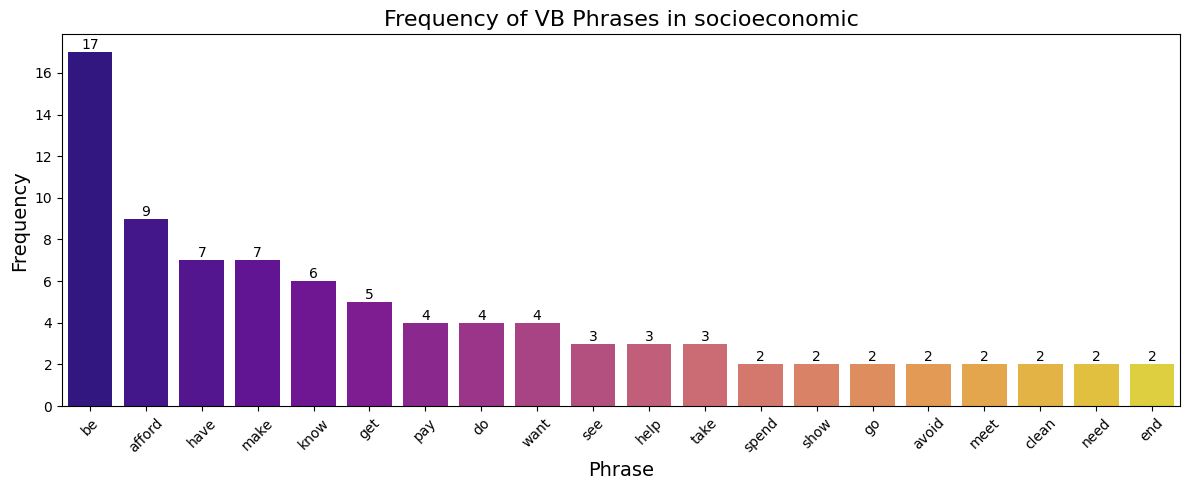

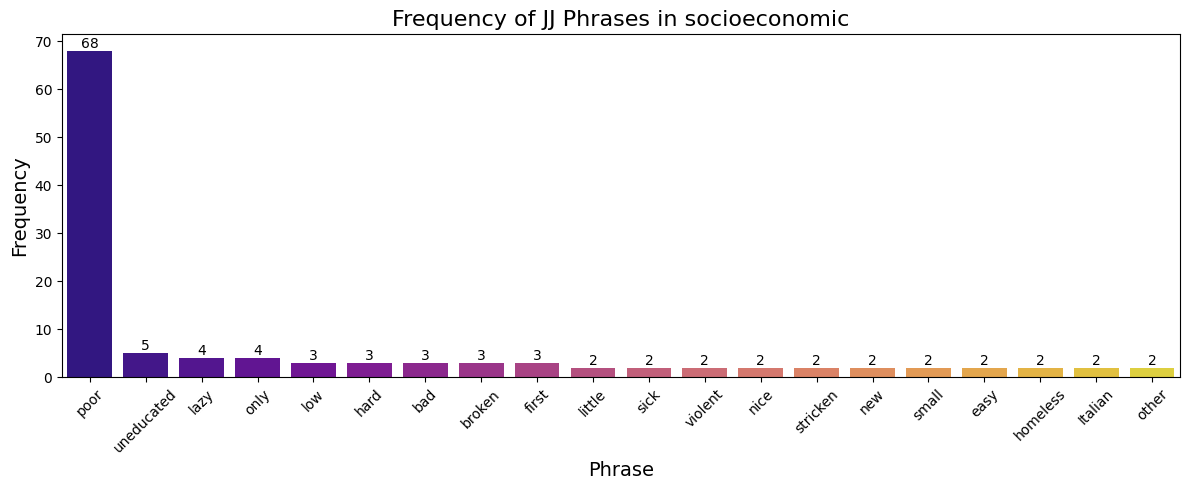

In [12]:
#get the most frequent words of a specific POS and bias type

def frequent_words(bias_type, POS):
    count_list = []
    filtered_df = dataset.loc[dataset["bias_type"] == bias_type]
    filtered_df.reset_index(drop=True, inplace=True)
    for i in range(len(filtered_df)):
        stereo_words = word_tokenize(filtered_df.loc[i, "sent_more"])
        stereo_words = nltk.pos_tag(stereo_words)
        stereo_words = filter(lambda x:x[1]==POS, stereo_words)
        for word in stereo_words:
            if word != "":
                count_list.append(word[0])
    c = Counter(count_list)
    top_20 = c.most_common(20)
    
    df = pd.DataFrame(top_20, columns=["Phrase", 'Frequency'])
    plt.figure(figsize=(12, 5))
    ax = sns.barplot(x='Phrase', y='Frequency', hue="Phrase", data=df, palette = "plasma")
    
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}',  # The frequency value
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),  # Offset for better visibility
                    textcoords='offset points')
    
    # Add labels and title
    plt.xlabel('Phrase', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    title= f"Frequency of {POS} Phrases in {bias_type}"
    plt.title(title, fontsize=16)
    
    # Show the plot
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

frequent_words("socioeconomic", "NN")
frequent_words("socioeconomic", "VB")
frequent_words("socioeconomic", "JJ")

## 11. Conclusion <a id="conclusion"></a>

In this notebook, we performed an exploratory data analysis of the CrowSPairs dataset. We examined the label distribution, sentence lengths, part-of-speech tags, and token frequencies. Additionally, we printed various example sentences, including standard examples, outliers, label-wise representatives, POS pattern-based examples, and token frequency-based examples. Understanding these aspects of the dataset is crucial for effective model training and can guide preprocessing steps.

In the next notebook, we will proceed to fine-tune the pre-trained ALBERT model on this dataset.

*Thank you for your attention! If you have any questions or need further clarification on any part of this notebook, feel free to ask.*